In [1]:
# Load modules and data
import os
import torch
from torch import optim, nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import torch.utils.tensorboard
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import torchmetrics
from pytorch_lightning.strategies.ddp import DDPStrategy
from sklearn.model_selection import train_test_split, StratifiedKFold
torch.multiprocessing.set_sharing_strategy('file_system')
import numpy as np
import pandas as pd
import monai
from monai.config import print_config
from monai.data import DataLoader, list_data_collate
from monai.transforms import *
import warnings
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:

SEED = 42

# choose if it should use full head CT or just masked images
MASKED = False

# Fold
FOLD = 0
OG = True

# determinism
torch.manual_seed(SEED)
monai.utils.set_determinism(seed=SEED, additional_settings=None)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.set_num_threads(1)
np.random.seed(SEED)

# Modellarchitektur definieren
resnet_model=monai.networks.nets.resnet50(
    pretrained=False,
    spatial_dims=3,
    n_input_channels=1, 
    num_classes=1)

if OG: 
    testfile = 'fold_og_test.xlsx'
else: 
    testfile = 'fold_test.xlsx'
print('FILENAME: ', testfile)

# Test     
dataset_test = pd.read_excel(testfile, index_col=0)
dataset_test = dataset_test.dropna()


if MASKED: 
    folder_path = "Dataset/voxel_standard_masked"
else:
    folder_path = "Dataset/voxel_standard_fullhead"
print('FOLDER_PATH: ', folder_path)


dataset_test['img'] = [os.path.join(folder_path, f"{x}.nii.gz") 
        for x in dataset_test.index]


FILENAME:  fold_og_test.xlsx
FOLDER_PATH:  Dataset/voxel_standard_fullhead


In [3]:
# put data in dataloader 
transforms_valtest = Compose(
    [
        LoadImaged(keys=["img"], ensure_channel_first=True),
        ToTensord(keys=['img'])

    ]
)
test_files = [{"img": img,
            "label": label} for 
            img, label in 
            zip(dataset_test.img,
                dataset_test.label)]

test_ds = monai.data.Dataset(data=test_files, transform=transforms_valtest)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

# Prepare a variable to insert the data there later
model_output = pd.DataFrame({"MRN": dataset_test.index})
model_output['labels'] = dataset_test['label'].tolist()


In [4]:
CHECKPOINT = [
    "Collection/version_3033490/c-epoch=167-val_loss_epoch=tensor(0.5776, device='cuda_0').ckpt",
    "Collection/version_3033525/c-epoch=167-val_loss_epoch=tensor(0.6086, device='cuda_0').ckpt",
    "Collection/version_3033567/c-epoch=281-val_loss_epoch=tensor(0.5935, device='cuda_0').ckpt",
    "Collection/version_3033675/c-epoch=69-val_loss_epoch=tensor(0.6515, device='cuda_0').ckpt",
    "Collection/version_3033705/c-epoch=133-val_loss_epoch=tensor(0.6156, device='cuda_0').ckpt"
]

PREDICT  0
PREDICT  1
PREDICT  2
PREDICT  3
PREDICT  4
PREDICT  5
PREDICT  6
PREDICT  7
PREDICT  8
PREDICT  9
PREDICT  10
PREDICT  11
PREDICT  12
PREDICT  13
PREDICT  14
PREDICT  15
PREDICT  16
PREDICT  17
PREDICT  18
PREDICT  19
PREDICT  20
PREDICT  21
PREDICT  22
PREDICT  23
PREDICT  24
PREDICT  25
PREDICT  26
PREDICT  27
PREDICT  28
PREDICT  29
PREDICT  30
PREDICT  31
PREDICT  32
PREDICT  33
PREDICT  34
PREDICT  35
PREDICT  36
PREDICT  37
PREDICT  38
PREDICT  39
PREDICT  40
PREDICT  41
PREDICT  42
PREDICT  43
PREDICT  44
PREDICT  45
PREDICT  46
PREDICT  47
PREDICT  48
PREDICT  49
PREDICT  50
PREDICT  51
PREDICT  52
PREDICT  53
PREDICT  54
PREDICT  55
PREDICT  56
PREDICT  57
PREDICT  58
PREDICT  59
PREDICT  60
PREDICT  61
PREDICT  62
PREDICT  63
PREDICT  64
PREDICT  65
PREDICT  66
PREDICT  67
PREDICT  68
PREDICT  69
PREDICT  70
PREDICT  71
PREDICT  72
PREDICT  73
PREDICT  74
PREDICT  75
PREDICT  76
PREDICT  77
PREDICT  78
PREDICT  79
PREDICT  80
PREDICT  81
PREDICT  82
PREDICT  83
PR

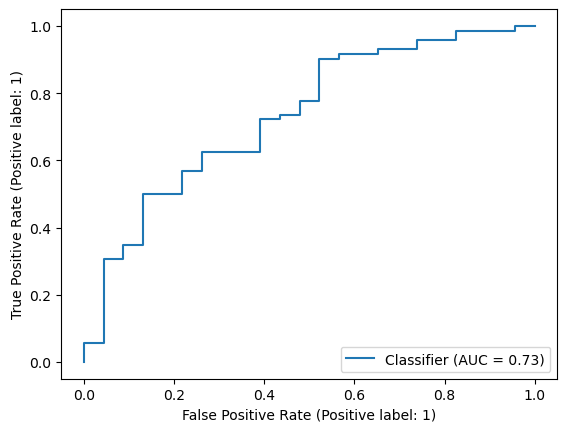

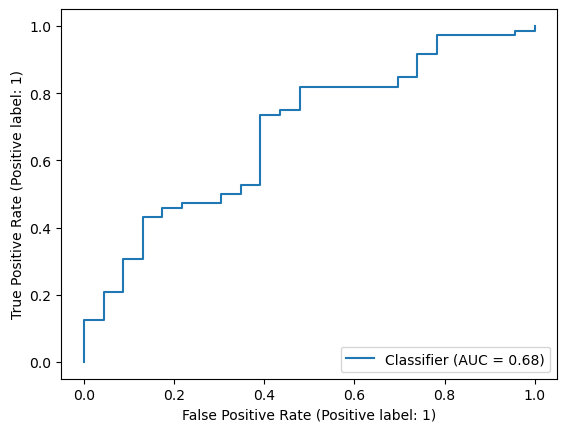

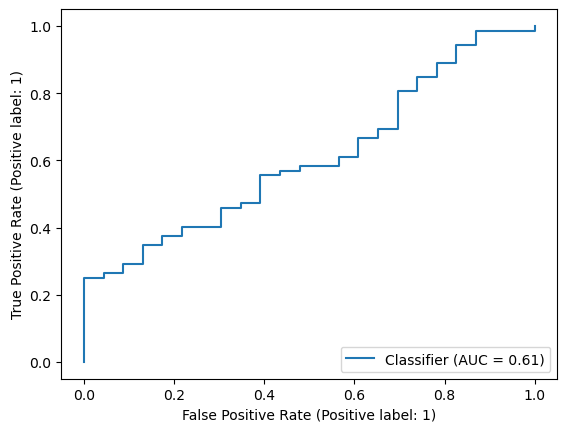

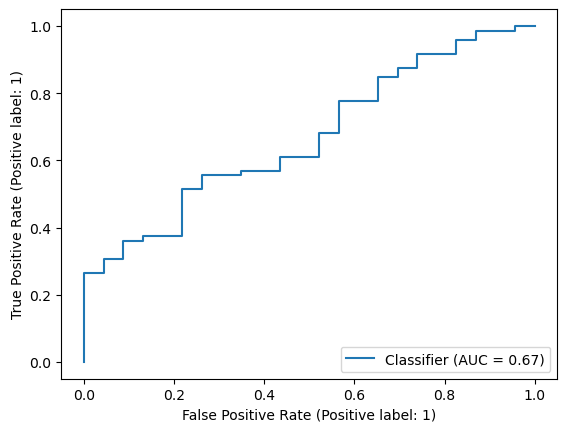

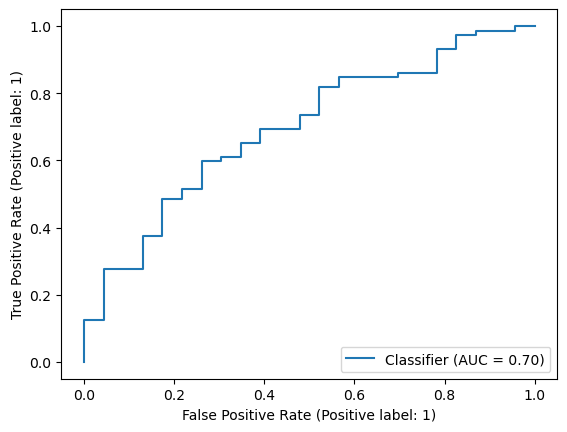

In [5]:
for j in range(5):
    ckpt = CHECKPOINT[j]
    checkpoint = torch.load(ckpt)
    weights_dict = {k.replace('_model.', ''): v for k, v in checkpoint['state_dict'].items()}
    model_dict = resnet_model.state_dict()
    model_dict.update(weights_dict)
    resnet_model.load_state_dict(model_dict)

    resnet_model.to(device)
    resnet_model.eval()
    # Create Train files
    test_output = []
    test_labels = []
    i = 0
    for batch in test_loader:
        # Move the input data to the training device
        img, labels = batch['img'].to(device), batch['label'].to(device)
        with torch.no_grad():
            outputs = resnet_model(img)
            outputs = torch.sigmoid(outputs)
            test_output.append(outputs.detach().cpu().numpy())
            test_labels.append(labels.detach().cpu().numpy())
        print('PREDICT ', i)
        i += 1
        #if i == 0: break
    
    # put the output together
    test_output = np.concatenate(test_output, axis=0)
    test_labels = np.stack(test_labels)
    model_output[f'output_{j}'] = test_output.T[0]
    RocCurveDisplay.from_predictions(test_labels, test_output)
 


In [1]:
model_output.to_csv('Img-t2-modelprediction-2.csv')

NameError: name 'model_output' is not defined

In [2]:
model_output = pd.read_csv('Img-t2-modelprediction-2.csv', index_col=0)
print(model_output)
model_output.set_index('MRN', inplace=True)
labels = model_output.pop('labels')
def checkoutput(n, thr):
    if n >= thr:
        return 1
    else: return 0

model_output

          MRN  labels  output_0  output_1  output_2  output_3  output_4
0   MR6052759       0  0.451274  0.531815  0.847706  0.600042  0.481606
1     MR95457       1  0.544785  0.571191  0.428819  0.638616  0.530893
2    MR278840       0  0.660713  0.733595  0.820762  0.669313  0.770100
3   MR2412133       1  0.585928  0.679912  0.691336  0.640672  0.693247
4   MR5821734       1  0.387840  0.539049  0.240788  0.609791  0.621533
..        ...     ...       ...       ...       ...       ...       ...
90   MR656895       1  0.652428  0.672140  0.638297  0.653853  0.710686
91  MR6499221       1  0.547467  0.683103  0.632409  0.610651  0.653284
92  MR4681252       1  0.569940  0.535142  0.659914  0.683733  0.512605
93  MR4186791       1  0.691703  0.805563  0.698553  0.676466  0.766513
94  MR2939649       0  0.644296  0.655129  0.729612  0.615439  0.745518

[95 rows x 7 columns]


,output_0,output_1,output_2,output_3,output_4
MRN,,,,,
MR6052759,0.451274,0.531815,0.847706,0.600042,0.481606
MR95457,0.544785,0.571191,0.428819,0.638616,0.530893
MR278840,0.660713,0.733595,0.820762,0.669313,0.770100
MR2412133,0.585928,0.679912,0.691336,0.640672,0.693247
MR5821734,0.387840,0.539049,0.240788,0.609791,0.621533
...,...,...,...,...,...
MR656895,0.652428,0.672140,0.638297,0.653853,0.710686
MR6499221,0.547467,0.683103,0.632409,0.610651,0.653284
MR4681252,0.569940,0.535142,0.659914,0.683733,0.512605


           output_0  output_1  output_2  output_3  output_4  output_0_class  \
MRN                                                                           
MR6052759  0.451274  0.531815  0.847706  0.600042  0.481606               0   
MR95457    0.544785  0.571191  0.428819  0.638616  0.530893               1   
MR278840   0.660713  0.733595  0.820762  0.669313  0.770100               1   
MR2412133  0.585928  0.679912  0.691336  0.640672  0.693247               1   
MR5821734  0.387840  0.539049  0.240788  0.609791  0.621533               0   
...             ...       ...       ...       ...       ...             ...   
MR656895   0.652428  0.672140  0.638297  0.653853  0.710686               1   
MR6499221  0.547467  0.683103  0.632409  0.610651  0.653284               1   
MR4681252  0.569940  0.535142  0.659914  0.683733  0.512605               1   
MR4186791  0.691703  0.805563  0.698553  0.676466  0.766513               1   
MR2939649  0.644296  0.655129  0.729612  0.615439  0

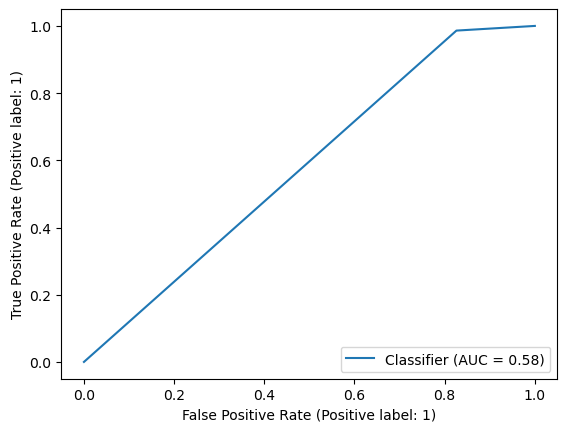

In [39]:

# Majority
for i in range(5):
    model_output[f'output_{i}_class'] = [checkoutput(i, 0.50) for i in model_output[f'output_{i}']]
def voting(df, MRN):
    l = list()
    for i in range(5):
        l.append(df.loc[MRN, f'output_{i}_class'])
    if sum(l) > 2: return 1
    else: return 0
model_output['decision'] = [voting(model_output,mrn) for mrn in model_output.index]
print(model_output)
score = roc_auc_score(labels, model_output.decision)
print(f"ROC AUC: {score:.4f}")
print(classification_report(labels, model_output.decision))
RocCurveDisplay.from_predictions(labels, model_output.decision)


              precision    recall  f1-score   support

           0       0.67      0.17      0.28        23
           1       0.79      0.97      0.87        72

    accuracy                           0.78        95
   macro avg       0.73      0.57      0.57        95
weighted avg       0.76      0.78      0.73        95



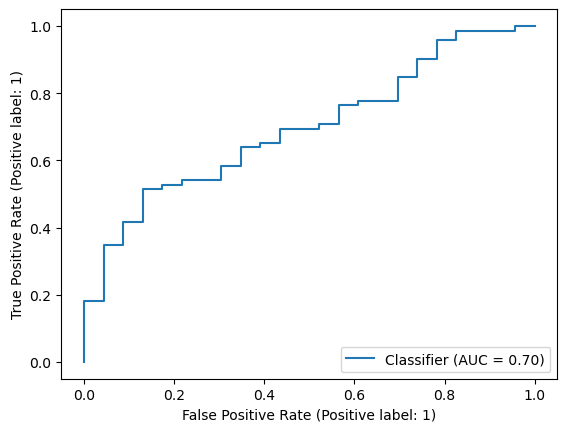

In [3]:

# Mean vote
model_output['mean_prob'] = model_output.mean(axis=1)
RocCurveDisplay.from_predictions(labels, model_output.mean_prob)

model_output['decision'] = [checkoutput(i, 0.50) for i in model_output.mean_prob]
print(classification_report(labels, model_output.decision))
model_output['labels'] = labels
model_output.to_csv('img-t2-modelprediction-mean.csv')

              precision    recall  f1-score   support

           0       0.80      0.17      0.29        23
           1       0.79      0.99      0.88        72

    accuracy                           0.79        95
   macro avg       0.79      0.58      0.58        95
weighted avg       0.79      0.79      0.73        95

